In [1]:
import xgboost as xgb
import pandas as pd 
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
import os
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
df0=pd.read_csv('/Users/bagusariyono/Downloads/training_set_VU_DM.csv')

In [4]:
df0.head(4)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0


In [5]:
# percentage of missing value of each collumn
1- df0.count()/len(df0)

srch_id                        0.000000
date_time                      0.000000
site_id                        0.000000
visitor_location_country_id    0.000000
visitor_hist_starrating        0.949204
visitor_hist_adr_usd           0.948977
prop_country_id                0.000000
prop_id                        0.000000
prop_starrating                0.000000
prop_review_score              0.001485
prop_brand_bool                0.000000
prop_location_score1           0.000000
prop_location_score2           0.219902
prop_log_historical_price      0.000000
position                       0.000000
price_usd                      0.000000
promotion_flag                 0.000000
srch_destination_id            0.000000
srch_length_of_stay            0.000000
srch_booking_window            0.000000
srch_adults_count              0.000000
srch_children_count            0.000000
srch_room_count                0.000000
srch_saturday_night_bool       0.000000
srch_query_affinity_score      0.935986


While visitor_hist_starrating, visitor_hist_adr_usd, gross_bookings_usd and srch_query_affinity_score contain more than 90% missing values, prop_review_score as well as orig_destination_distance only experienced in similar concern around 30% and 0.1% respectively. To deal with it, we ultilize the negative as well as groupby imputing approach

In [5]:
# Build up target feature Click = 1, book and click = 2 then no book no click = 0

In [36]:
conditions = [
    df0['booking_bool'].eq(0) & df0['click_bool'].eq(1),
     df0['booking_bool'].eq(1) & df0['click_bool'].eq(1),
     df0['booking_bool'].eq(0) & df0['click_bool'].eq(0),]
choices = ['click','book','C']
df0['book_click'] = np.select(conditions, choices, default=0)

In [54]:
len(df0[(df0.booking_bool==1)&(df0.click_bool==1) ])

138390

In [55]:
len(df0[(df0.click_bool==1) & (df0.booking_bool==0)])

83489

In [38]:
df0.nunique()

srch_id                        199795
date_time                      198615
site_id                            34
visitor_location_country_id       210
visitor_hist_starrating           312
visitor_hist_adr_usd             7799
prop_country_id                   172
prop_id                        129113
prop_starrating                     6
prop_review_score                  10
prop_brand_bool                     2
prop_location_score1              337
prop_location_score2             9342
prop_log_historical_price         392
position                           40
price_usd                       76465
promotion_flag                      2
srch_destination_id             18127
srch_length_of_stay                36
srch_booking_window               429
srch_adults_count                   9
srch_children_count                10
srch_room_count                     8
srch_saturday_night_bool            2
srch_query_affinity_score      199387
orig_destination_distance      530595
random_bool 

In [39]:
df0.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,book_click
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,C
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,C
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,C
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0,C
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,C


In [40]:
# check the correlation metrix 
corr = df0.corr()
corr.style.background_gradient(cmap='coolwarm')

In [12]:
# summary statistic
df0.describe()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
count,4.958347e+06,4.958347e+06,4.958347e+06,251866.000000,252988.000000,4.958347e+06,4.958347e+06,4.958347e+06,4.950983e+06,4.958347e+06,...,96174.000000,315348.000000,356422.000000,138515.000000,1.916654e+06,1.987503e+06,614730.000000,4.958347e+06,138390.000000,4.958347e+06
mean,1.663666e+05,9.953133e+00,1.753405e+02,3.374334,176.022659,1.739739e+02,7.007918e+04,3.180525e+00,3.777777e+00,6.346994e-01,...,17.250473,0.145969,0.083202,19.433267,-6.089936e-02,9.962752e-03,22.430384,4.474858e-02,386.283316,2.791051e-02
std,9.611223e+04,7.646890e+00,6.591625e+01,0.692519,107.254493,6.834525e+01,4.060992e+04,1.051024e+00,1.050329e+00,4.815144e-01,...,31.160313,0.578202,0.316722,54.370221,4.691723e-01,2.029142e-01,895.965854,2.067514e-01,821.190577,1.647165e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.410000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000,-1.000000,-1.000000,2.000000,-1.000000e+00,-1.000000e+00,2.000000,0.000000e+00,0.000000,0.000000e+00
25%,8.293600e+04,5.000000e+00,1.000000e+02,2.920000,109.810000,1.000000e+02,3.501000e+04,3.000000e+00,3.500000e+00,0.000000e+00,...,6.000000,0.000000,0.000000,7.000000,0.000000e+00,0.000000e+00,7.000000,0.000000e+00,124.000000,0.000000e+00
50%,1.665070e+05,5.000000e+00,2.190000e+02,3.450000,152.240000,2.190000e+02,6.963800e+04,3.000000e+00,4.000000e+00,1.000000e+00,...,11.000000,0.000000,0.000000,12.000000,0.000000e+00,0.000000e+00,11.000000,0.000000e+00,218.400000,0.000000e+00
75%,2.497240e+05,1.400000e+01,2.190000e+02,3.930000,213.490000,2.190000e+02,1.051680e+05,4.000000e+00,4.500000e+00,1.000000e+00,...,18.000000,1.000000,0.000000,20.000000,0.000000e+00,0.000000e+00,17.000000,0.000000e+00,429.790000,0.000000e+00
max,3.327850e+05,3.400000e+01,2.310000e+02,5.000000,1958.700000,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,...,1620.000000,1.000000,1.000000,9900.000000,1.000000e+00,1.000000e+00,149400.000000,1.000000e+00,159292.380000,1.000000e+00


### So now 1st task missing value challenge, I create df1

Treat all missing value greater than 90% with negative imputed value

visitor_hist_starrating ( imputed with -1, You might think of them as place holders letting you use all your observed data rather than dropping observations with missing values. if we add 0, it will mislead the no review score before. if we add mean, it will bias since most of book placed in 219, 100..then then better to use (-1)= no info available ,put them in one set to separate with other scores )


visitor_hist_adr_usd, ( imputed -1, same reasoning)

gross_bookings_usd   ( imputed -1, same reasoning if 0 equal non booking - not reflect true picture)

srch_query_affinity_score  ( imputed -1, same reasoning)

prop_review_score ( imputed with average score groupby prop_starrating since 2 varaible has high collreation, if high start means it has high hotel standard and high probability to please customer to gain high score)

prop_location_score2 ( imputed with average score groupby prop_location_score1 since 2 varaible has high collreation, if high score 1 and in score 2 it also have probility to get high score)

orig_destination_distance (imputed missing values with 0 since non available data same as not be calculated, do not need -1 to mislead)


In [41]:
df1=df0.copy()

In [42]:
df1.visitor_hist_starrating.fillna(-1, inplace=True)
df1.visitor_hist_adr_usd.fillna(-1, inplace=True)
df1.gross_bookings_usd.fillna(-1, inplace=True)
df1.srch_query_affinity_score.fillna(-1, inplace=True)
df1.orig_destination_distance.fillna(0, inplace=True)

In [43]:
df1['prop_review_score']=df1.groupby('prop_starrating')['prop_review_score'].transform(lambda x: x.fillna(x.mean()))
df1['prop_location_score2']=df1.groupby('prop_location_score1')['prop_location_score2'].transform(lambda x: x.fillna(x.mean()))

In [44]:
# round up to get review score same as 'prop_starrating' in same scale
df1['prop_review_score']= ((df1['prop_review_score']*10**0+0.5)/10**0).apply(np.floor,1)

In [45]:
# there are some prop_location_score2 dont have group in score 1 then, imputed 2 remainder values with average
df1['prop_location_score2'].fillna(value=df1['prop_location_score2'].mean(), inplace=True)

In [46]:
1- df1.count()/len(df1)

srch_id                        0.000000
date_time                      0.000000
site_id                        0.000000
visitor_location_country_id    0.000000
visitor_hist_starrating        0.000000
visitor_hist_adr_usd           0.000000
prop_country_id                0.000000
prop_id                        0.000000
prop_starrating                0.000000
prop_review_score              0.000000
prop_brand_bool                0.000000
prop_location_score1           0.000000
prop_location_score2           0.000000
prop_log_historical_price      0.000000
position                       0.000000
price_usd                      0.000000
promotion_flag                 0.000000
srch_destination_id            0.000000
srch_length_of_stay            0.000000
srch_booking_window            0.000000
srch_adults_count              0.000000
srch_children_count            0.000000
srch_room_count                0.000000
srch_saturday_night_bool       0.000000
srch_query_affinity_score      0.000000


### So now 2nd task data visulization

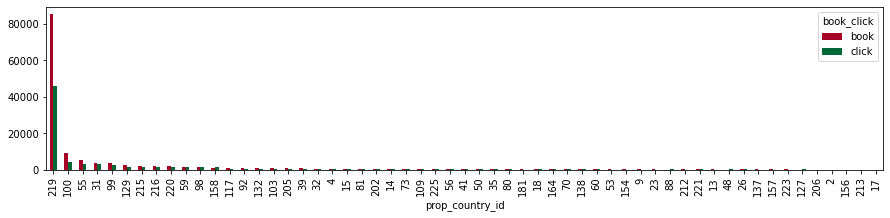

In [149]:
# top countries has been  clicked in which country 
df1_booked = df1[df1['book_click'] != 'C'] 
hotel_country= df1_booked.groupby('prop_country_id').book_click.value_counts()
hotel_country=hotel_country.nlargest(100)
hotel_country.unstack().plot.bar(stacked= False, figsize = (15,3), color= plt.cm.RdYlGn(np.linspace(0,1,2)))

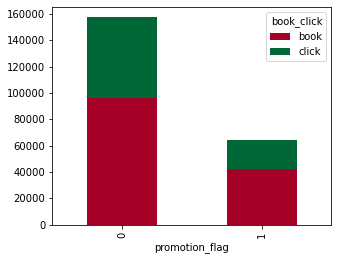

In [150]:
# the distribution of promotion flag attract to click and book

#subset dataset for book and click only
df1_book_click = df1[((df1.book_click.isin(["click","book"])))]

country_book_click=df1_book_click.groupby('promotion_flag').book_click.value_counts()
#country_book_click=country_book_click.nlargest(20)
country_book_click.unstack().plot.bar(stacked= True, figsize = (5,4), color= plt.cm.RdYlGn(np.linspace(0,10,10)))

In [ ]:
# hotel with promotion booked is lower? this is because we use count instead of proportion
# the comparation is not fair

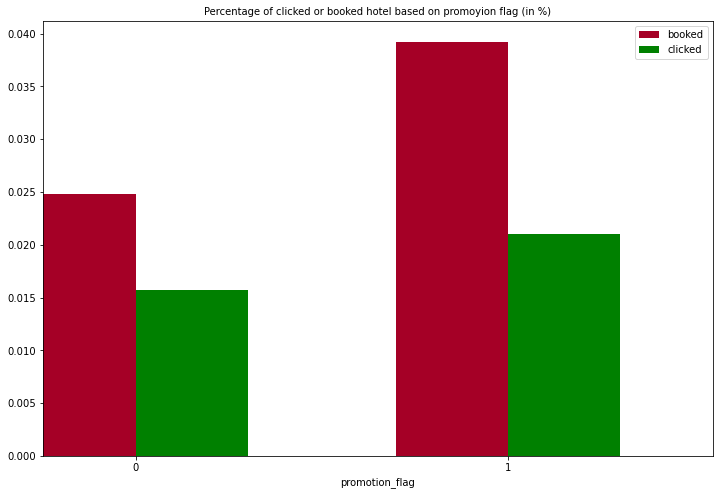

In [151]:
book_sales= (df1['booked'].groupby(df1['promotion_flag']).mean()).to_frame()
click_sales = (df1['clicked'].groupby(df1['promotion_flag']).mean()).to_frame()

fig = plt.figure()
ax = fig.add_subplot()
width = 0.3
book_sales.plot.bar( figsize=(12,8),width = width,ax=ax,rot=0,position=1,color= plt.cm.RdYlGn(np.linspace(0,10,10)))
click_sales.plot.bar( figsize=(12,8),width = width,ax=ax,rot=0,position=0,color='green')

ax.set_title("Percentage of clicked or booked hotel based on promoyion flag (in %)", fontsize =10);
plt.show()

In [ ]:
#Using mean gives a more sense result as now the probability of booked or clicked is higher for hotel with promotion flag

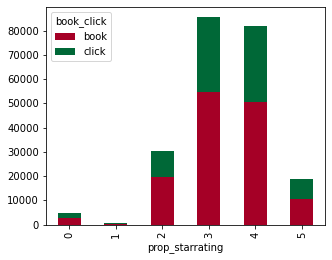

In [152]:
# the distribution of star rating attract to click and book
country_book_click=df1_book_click.groupby('prop_starrating').book_click.value_counts()
#country_book_click=country_book_click.nlargest(20)
country_book_click.unstack().plot.bar(stacked= True, figsize = (5,4), color= plt.cm.RdYlGn(np.linspace(0,10,10)))

In [ ]:
#notes: this is not a fair comparison to say that star 3 or 4 hotel is more likely will be booked
# the graphs are higher simply because the numbers of hotel are larger
# to have a fair comparison use groupby mean

In [153]:
df1.groupby('prop_starrating').count()['prop_id']

prop_starrating
0     169572
1      17350
2     895894
3    1947598
4    1521448
5     406485
Name: prop_id, dtype: int64

In [ ]:
#using percentage instead of count

In [154]:
#create numeric identifier
df1['clicked'] =0
df1.loc[df1.book_click == 'click','clicked']=1
df1['booked'] =0
df1.loc[df1.book_click == 'book','booked']=1

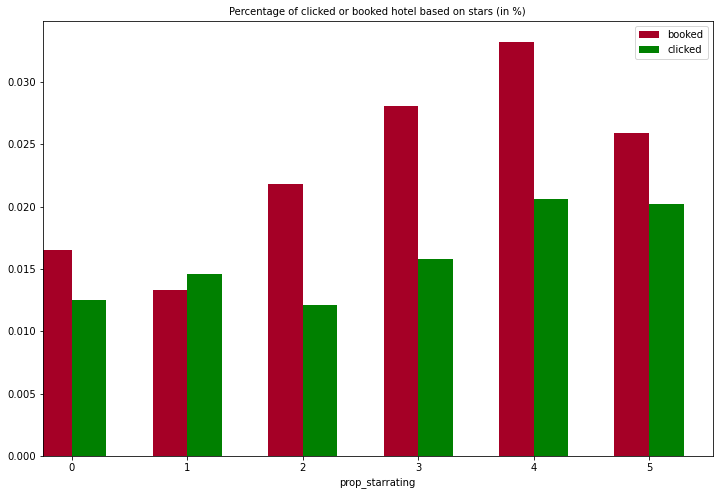

In [155]:
book_stars = (df1['booked'].groupby(df1['prop_starrating']).mean()).to_frame()
click_stars = (df1['clicked'].groupby(df1['prop_starrating']).mean()).to_frame()

fig = plt.figure()
ax = fig.add_subplot()
width = 0.3
book_stars.plot.bar( figsize=(12,8),width = width,ax=ax,rot=0,position=1,color= plt.cm.RdYlGn(np.linspace(0,10,10)))
click_stars.plot.bar( figsize=(12,8),width = width,ax=ax,rot=0,position=0,color='green')

ax.set_title("Percentage of clicked or booked hotel based on stars (in %)", fontsize =10);
plt.show()

In [ ]:
#the result is more or less similar (3 & 4 are more likely booked or clicked), but now the comparation is fair

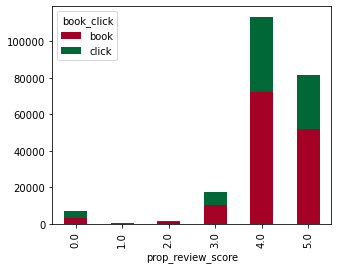

In [156]:
# the distribution of previous review  attract to click and book
country_book_click=df1_book_click.groupby('prop_review_score').book_click.value_counts()
#country_book_click=country_book_click.nlargest(20)
country_book_click.unstack().plot.bar(stacked= True, figsize = (5,4), color= plt.cm.RdYlGn(np.linspace(0,10,10)))

In [ ]:
#Again, it is not a fair comparison

In [158]:
df1.groupby('prop_review_score').count()['prop_id']

prop_review_score
0.0     233294
1.0      13303
2.0      76766
3.0     522022
4.0    2330135
5.0    1782827
Name: prop_id, dtype: int64

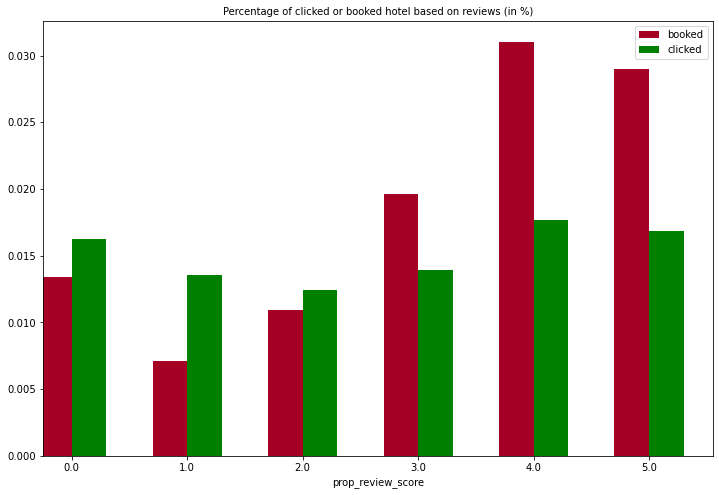

In [157]:
book_reviews = (df1['booked'].groupby(df1['prop_review_score']).mean()).to_frame()
click_reviews = (df1['clicked'].groupby(df1['prop_review_score']).mean()).to_frame()

fig = plt.figure()
ax = fig.add_subplot()
width = 0.3
book_reviews.plot.bar( figsize=(12,8),width = width,ax=ax,rot=0,position=1,color= plt.cm.RdYlGn(np.linspace(0,10,10)))
click_reviews.plot.bar( figsize=(12,8),width = width,ax=ax,rot=0,position=0,color='green')

ax.set_title("Percentage of clicked or booked hotel based on reviews (in %)", fontsize =10);
plt.show()

In [ ]:
#the higher the review score the higher click and book

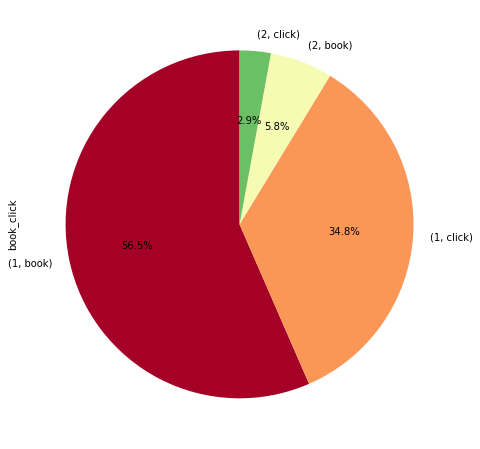

In [159]:
# choose top 3 room category in which hotel has been booked and clicked most
# choose only booked and clicked hotel only, then find which is the most preference room number has been booked , 1 and 2 room are prefereable
room= df1_book_click.groupby('srch_room_count').book_click.value_counts()
room=room.nlargest(4)
room.plot.pie( figsize = (8,8), autopct ='%1.1f%%', startangle =90, colors= plt.cm.RdYlGn(np.linspace(0,5,20)))

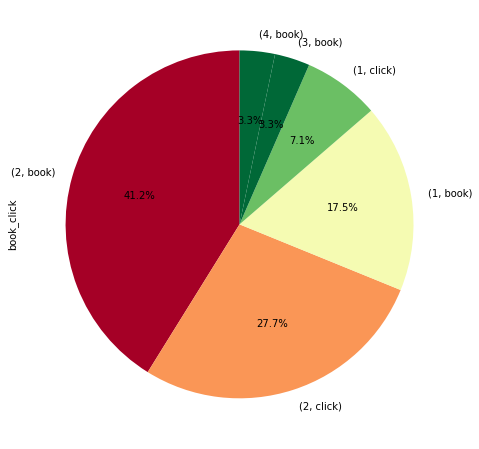

In [172]:
# choose top 3 number of adults category  has been booked and clicked most
# choose only booked and clicked hotel only, then find which is the most preference room number has been booked , 1 and 2 room are prefereable
adult= df1_book_click.groupby('srch_adults_count').book_click.value_counts()
adult=adult.nlargest(6)
adult.plot.pie( figsize = (8,8), autopct ='%1.1f%%', startangle =90, colors= plt.cm.RdYlGn(np.linspace(0,5,20)))

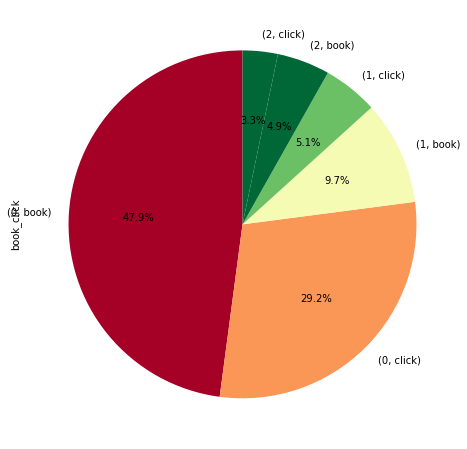

In [171]:
# choose top 3 number of childrend category in which hotel has been booked and clicked most
# choose only booked and clicked hotel only, then find which is the most preference room number has been booked , 1 and 2 room are prefereable
children= df1_book_click.groupby('srch_children_count').book_click.value_counts()
children=children.nlargest(6)
children.plot.pie( figsize = (8,8), autopct ='%1.1f%%', startangle =90, colors= plt.cm.RdYlGn(np.linspace(0,5,20)))

In [162]:
#3 plots show that most search ended up with booking is 1 room, 2 adults, and 0 children
# But the problem is, the goal of the algorithm is to rank hotel for each search
# which means all hotels have a same value regarding this, so it explains nothing about which hotel is more preferrable

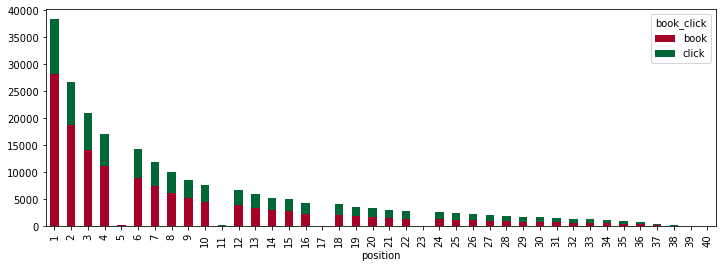

In [163]:
country_book_click=df1_book_click.groupby('position').book_click.value_counts()
#country_book_click=country_book_click.nlargest(100)
country_book_click.unstack().plot.bar(stacked= True, figsize = (12,4), color= plt.cm.RdYlGn(np.linspace(0,10,10)))

In [164]:
#its difficult to see whether the number of clicked for position 1 is higher than 2 or no

In [165]:
# suggestion

In [166]:
#Nonrandom order of hotels
nonrandom = df1[df1.random_bool==0]

In [167]:
#Random
random = df1[df1.random_bool==1]

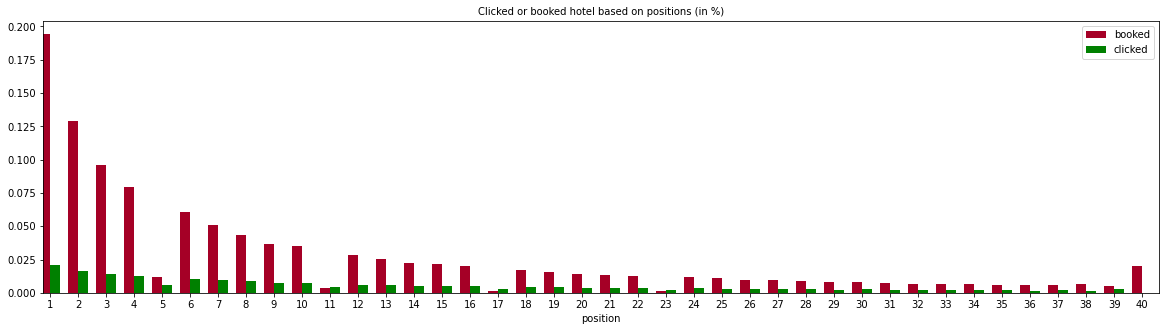

In [169]:
nonrandom_book_position = (nonrandom['booked'].groupby(nonrandom['position']).mean()).to_frame()
nonrandom_click_position = (nonrandom['clicked'].groupby(nonrandom['position']).mean()).to_frame()

fig = plt.figure()
ax = fig.add_subplot()
width = 0.35
nonrandom_book_position.plot.bar( figsize=(20,5),width = width,ax=ax,rot=0,position=1,color= plt.cm.RdYlGn(np.linspace(0,10,10)))
nonrandom_click_position.plot.bar( figsize=(20,5),width = width,ax=ax,rot=0,position=0,color='green')

ax.set_title("Clicked or booked hotel based on positions (in %)", fontsize =10);
plt.show()

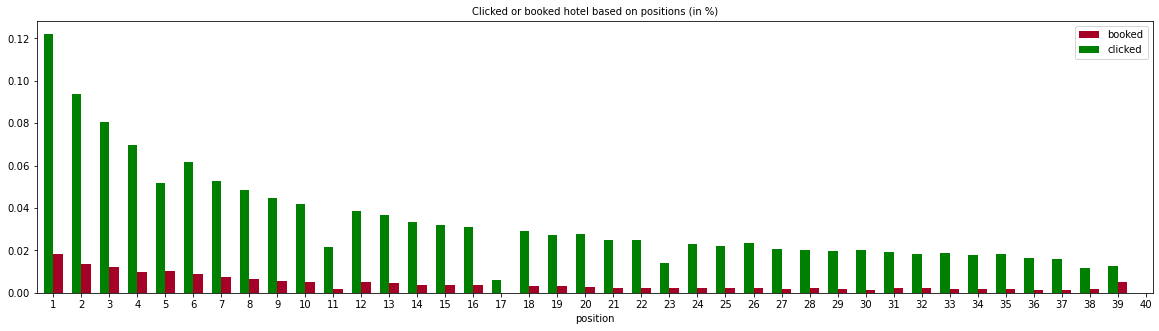

In [170]:
random_book_position = (random['booked'].groupby(random['position']).mean()).to_frame()
random_click_position = (random['clicked'].groupby(random['position']).mean()).to_frame()

fig = plt.figure()
ax = fig.add_subplot()
width = 0.35
random_book_position.plot.bar( figsize=(20,5),width = width,ax=ax,rot=0,position=0,color= plt.cm.RdYlGn(np.linspace(0,10,10)))
random_click_position.plot.bar( figsize=(20,5),width = width,ax=ax,rot=0,position=1,color='green')

ax.set_title("Clicked or booked hotel based on positions (in %)", fontsize =10);
plt.show()

In [147]:
# the hihgher position higher click and book (the information are same but the graph is better in my opinion) fell free to discuss tomorrow

### So now 3th task feature creation